## Demo PyHeat Youri & Mathis

Ceci est une notebook de démo pour la lib pyheat.
C'est une version temporaire

Toutes les valeurs utilisées dans ce notebook sont totalement arbitraires.
L'objectif n'est pas de montré des résultats mais le fonctionnement de la lib et ses entrées/sorties.

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from datetime import datetime

times = [datetime.fromtimestamp(100*k) for k in range(500)]

col_dict = {
	"river_bed": 1., #Profondeur lit de rivière
    "depth_sensors": [.1, .2, .3, .4], # Profondeur ou sont les capteurs
												# Premier etant riviere, ensuite autres, ensuite aquifere
	"delta_h": .05, # Decalage de profondeur des capteurs
    "dH_measures": list(zip(times, .04*np.random.rand(500))),
    "T_riv": list, # Meme format que P_measure pour capteur a la riviere
	"T_aq": list, # Meme format que P_measure pour capteur a l’aquifere
	"T_measures": list(zip(times, np.array(500*[[310.15, 308, 302, 285.15]])+2*np.random.rand(500,4)-1)),
    "sigma_meas_P": None, #float
    "sigma_meas_T": None, #float
}

col = Column.from_dict(col_dict)

In [3]:
#Peut définir un tuple avec la class Param (NamedTuple)
params = Param(
    moinslog10K = 4,
    n = .1,
    lambda_s = 2,
    rhos = 1000,
    cs = 4000
)

#Ou en tuple plus classiquement
params_tuple = (4, .1, 2, 1000, 4000)

assert params == params_tuple

In [4]:
col.compute_solve_transi(params, 41)

temps = col.temps_solve

col.compute_solve_transi(params_tuple, 41)

temps_from_tuple = col.temps_solve

assert np.array_equal(temps, temps_from_tuple)

Text(0, 0.5, 'time (s)')

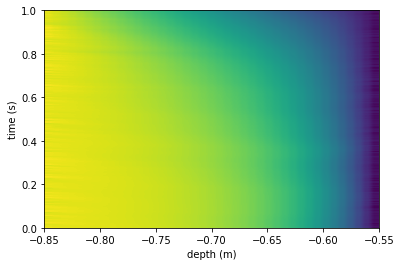

In [5]:
#Tout est stocké dans la class col pour ne pas avoir à le stocker hors de la class
fig, ax = plt.subplots(facecolor = 'w')

ax.imshow(
    col.temps_solve,
    aspect = "auto",
    extent = [col.depths_solve[0], col.depths_solve[-1], 0, 1] #TODO : trouver comment monter le datetime
)

ax.set_xlabel("depth (m)")
ax.set_ylabel("time (s)")

Text(17.200000000000003, 0.5, 'temperature (K)')

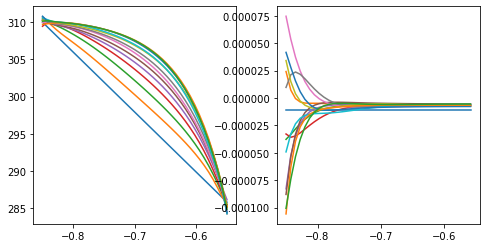

In [6]:
from itertools import islice

fig, axs = plt.subplots(1, 2, figsize=(8,4),facecolor = 'w')

ite = zip(
    col.temps_solve,
    col.flows_solve,
    col.times_solve
)

for temps, flows, t in islice(ite, 0, None, 40):
    axs[0].plot(
        col.depths_solve,
        temps,
        label = f"{t:.1e}"
    )
    axs[1].plot(
        col.depths_solve[:-1],
        flows,
        label = f"{t:.1e}"
    )

ax.set_xlabel("depth (m)")
ax.set_ylabel("temperature (K)")
#axs[1].legend()

Index 8 in z_array -> -0.7899999999999999
Temp at index 8 and t = 0-> 305.165
Temp at -0.790 -> 305.165
col.get_temps correct inaccuracy in z.
Temp at -0.789 -> 305.165


Text(0, 0.5, 'temperature (K)')

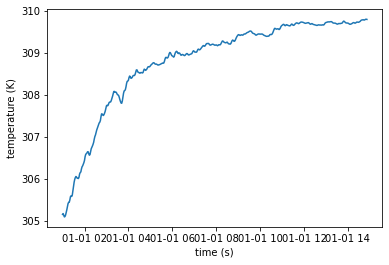

In [7]:
ind = 8
print(f"Index {ind} in z_array -> {col.depths_solve[ind]}")
print(f"Temp at index {ind} and t = 0-> {col.temps_solve[0, ind]:.3f}")
print(f"Temp at {col.depths_solve[ind]:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind])[0]:.3f}")
print("col.get_temps correct inaccuracy in z.")
print(f"Temp at {col.depths_solve[ind]+1e-3:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind]+1e-4)[0]:.3f}")

fig, ax = plt.subplots(facecolor = 'w')
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind]))
ax.set_xlabel("time (s)")
ax.set_ylabel("temperature (K)")

#TODO : Faire la meme avec le temps en paramètre

In [8]:
priors = {
    "moinslog10K": ((3, 10), 1), # (intervalle, sigma)
    "n": ((.01, .25), .06),
    "lambda_s": ((1, 5), .5),
    "rhos": ((500,1500), 100),
    "cs": ((3500, 4500), 100)
}

col.compute_mcmc(
    nb_iter = 1000,
    priors = priors,
    nb_cells = 41
)

Mcmc Computation : 100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s]


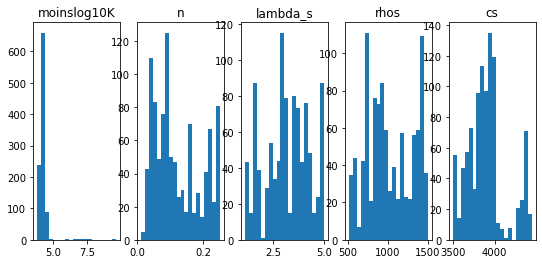

In [9]:
fig, axes = plt.subplots(1, 5, figsize = (9,4), facecolor = 'w')

ite = zip(
    ["moinslog10K", "n", "lambda_s", "rhos", "cs"],
    [col.all_moinslog10K, col.all_n, col.all_lambda_s, col.all_rhos, col.all_cs] 
)

for (lbl, vals), ax in zip(ite, axes):
    ax.hist(vals, bins = 20)
    ax.set_title(lbl)
#col.get_all_n et ses dérivés sont aussi dispo sous forme de méthodes

Text(0, 0.5, 'acceptance')

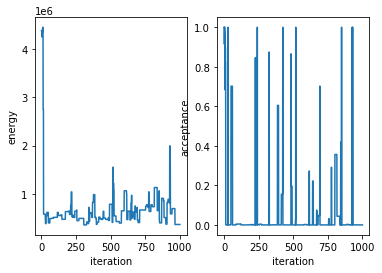

In [10]:
fig, axs = plt.subplots(1,2,facecolor = 'w')
axs[0].plot(col.all_energy)
axs[1].plot(col.all_acceptance_ratio)

axs[0].set_xlabel("iteration")
axs[0].set_ylabel("energy")
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("acceptance")

Parametres(moinslog10K=4.251804764119542, n=0.20324538620298288, lambda_s=2.3768414038431023, rhos=572.2338822622381, cs=3997.7826548199428)


Text(0, 0.5, 'time (s)')

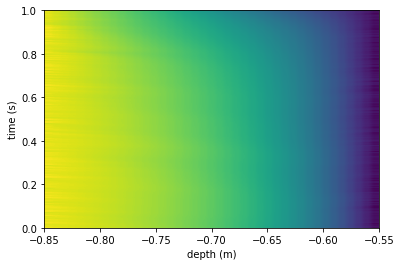

In [11]:
#Can also sample param from mcmc trajectory
sampled_params = col.sample_param()
print(sampled_params)

col.compute_solve_transi(sampled_params, 41)

fig, ax = plt.subplots(facecolor = 'w')

ax.imshow(
    col.temps_solve,
    aspect = "auto",
    extent = [col.depths_solve[0], col.depths_solve[-1], 0, 1]
)

ax.set_xlabel("depth (m)")
ax.set_ylabel("time (s)")

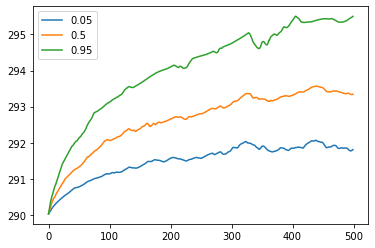

In [12]:
fig, ax = plt.subplots(facecolor = 'w')

#Pas encore possible de donner le temps encore.
for prof in col.get_temps_quantile(z = -.6, quantile = [.05, .5, .95]):
    ax.plot(prof)
    
ax.legend([.05, .5, .95])

In [13]:
col.get_temps_quantile(z = .1, quantile = [.3,.7]).shape

(2, 500)

In [14]:
from datetime import datetime